This notebook fits the baseline model. It predicts on the test data without doing any feature engineering, using the xgboost library.

In [63]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

df_train = pd.read_csv('data/train.csv').drop(['id'], axis=1)
df_train['source'] = 'simulation'

df_test = pd.read_csv('data/test.csv')
test_ids = df_test.id
dt_test = df_test.drop(['id'], axis=1)

df_supp = pd.read_csv('data/cirrhosis.csv').drop(['ID'], axis=1)
df_supp['source'] = 'original'

# merge supplemental data
df_train = pd.concat([df_train, df_supp]).reset_index(drop=True)
train_target = df_train['Status']

# list of discrete columns
TARGET = 'Status'
CAT_FEATS = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']
NUM_FEATS = [x for x in df_train.columns if x not in CAT_FEATS and x != TARGET]
NUM_FEATS.remove('source')
ORIG_FEATS = df_train.drop(TARGET, axis=1).columns.tolist()
print(ORIG_FEATS)
print(len(ORIG_FEATS))
print(df_train.dtypes)

['N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'source']
19
N_Days             int64
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
Status            object
source            object
dtype: object


# Exploratory Data Analysis

In [64]:
print(f'shape: {df_train.shape}')

shape: (8323, 20)


In [65]:
desc_df = df_train.describe(include="all")
desc_df = desc_df.T
desc_df['unique'] = desc_df['unique'].fillna(df_train.nunique())
desc_df['count'] = desc_df['count'].astype('int16')
desc_df['missing'] = df_train.shape[0] - desc_df['count']
desc_df['dtypes'] = df_train.dtypes
desc_df

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,missing,dtypes
N_Days,8323,495,NaN,NaN,2024.528776,1094.968696,41.0,1220.0,1831.0,2689.0,4795.0,0,int64
Drug,8217,2,Placebo,4164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106,object
Age,8323,397,NaN,NaN,18381.192359,3686.832308,9598.0,15574.0,18713.0,20684.0,28650.0,0,int64
Sex,8323,2,F,7710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,object
Ascites,8217,2,N,7813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106,object
Hepatomegaly,8217,2,Y,4202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106,object
Spiders,8217,2,N,6188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106,object
Edema,8323,3,N,7515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,object
Bilirubin,8323,117,NaN,NaN,2.62594,3.847146,0.3,0.7,1.1,3.0,28.0,0,float64
Cholesterol,8189,227,NaN,NaN,351.219074,196.775246,120.0,248.0,299.0,392.0,1775.0,134,float64


- Missing values are present but not frequent
- only 50 unique values of "Prothrombin"

dig into missingness:

In [66]:
for column in CAT_FEATS:
    print(df_train.loc[:, column].value_counts())

Drug
Placebo            4164
D-penicillamine    4053
Name: count, dtype: int64
Sex
F    7710
M     613
Name: count, dtype: int64
Ascites
N    7813
Y     404
Name: count, dtype: int64
Hepatomegaly
Y    4202
N    4015
Name: count, dtype: int64
Spiders
N    6188
Y    2029
Name: count, dtype: int64
Edema
N    7515
S     443
Y     365
Name: count, dtype: int64
Stage
3.0    3308
4.0    2847
2.0    1744
1.0     418
Name: count, dtype: int64


/home/reed/miniconda3/envs/ml/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/reed/miniconda3/envs/ml/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/reed/miniconda3/envs/ml/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/reed/miniconda3/envs/ml/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

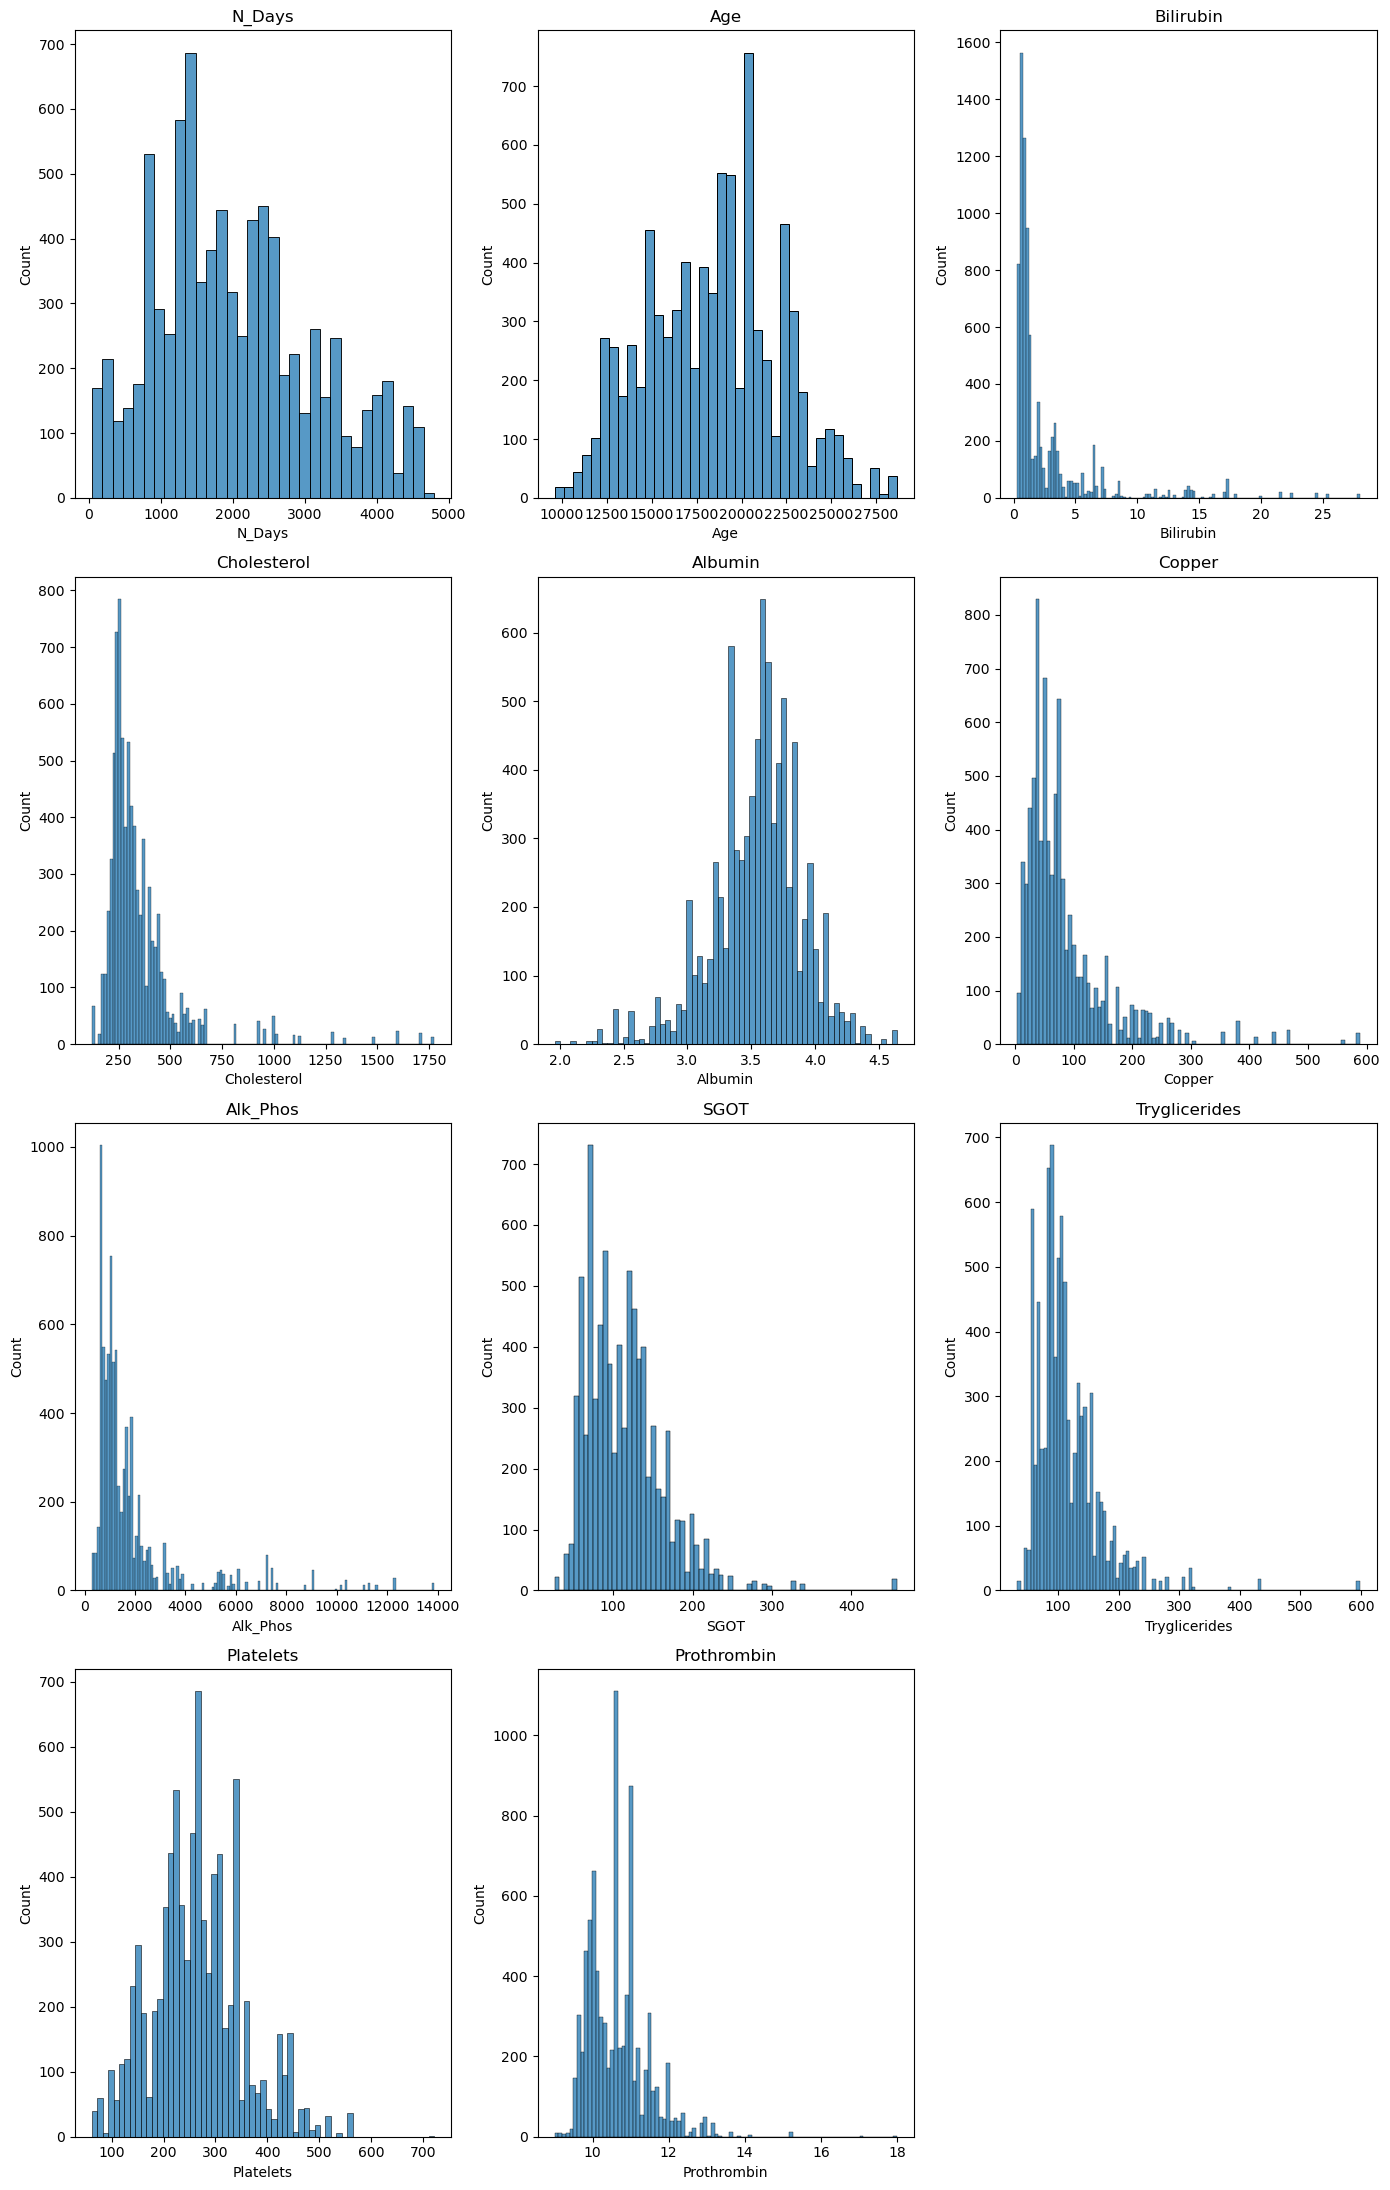

In [67]:
plt.figure(figsize=(14, len(NUM_FEATS) * 2))
for i, col in enumerate(NUM_FEATS):
    plt.subplot(len(CAT_FEATS) // 2 + 1, 3, i + 1)
    sns.histplot(x=col, data=df_train)
    plt.title(f"{col}")
    plt.tight_layout()

Several variables are skewed. Let's see if a logarithmic transformation will help with the outliers.

/home/reed/miniconda3/envs/ml/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/reed/miniconda3/envs/ml/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/reed/miniconda3/envs/ml/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/reed/miniconda3/envs/ml/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

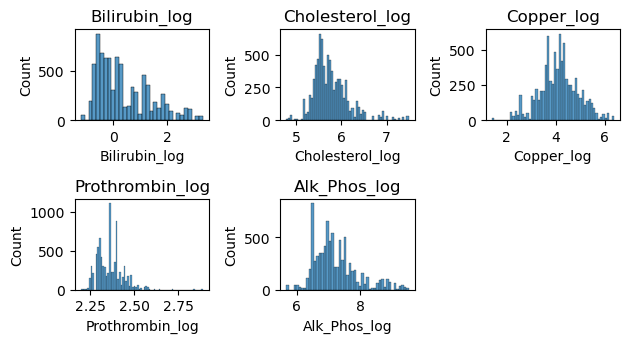

In [68]:
SKEWED_FEATS = ['Bilirubin', 'Cholesterol', 'Copper', 'Prothrombin', 'Alk_Phos']
df_log_feats = pd.DataFrame()
for col in SKEWED_FEATS:
    name = f'{col}_log'
    df_log_feats[name] = np.log(df_train[col])
    
for i, col in enumerate(df_log_feats.columns):
    plt.subplot(len(df_log_feats.columns) // 2 + 1, 3, i + 1)
    sns.histplot(x=col, data=df_log_feats)
    plt.title(f"{col}")
    plt.tight_layout()

This is probably an improvement.


Distribution of the Target:

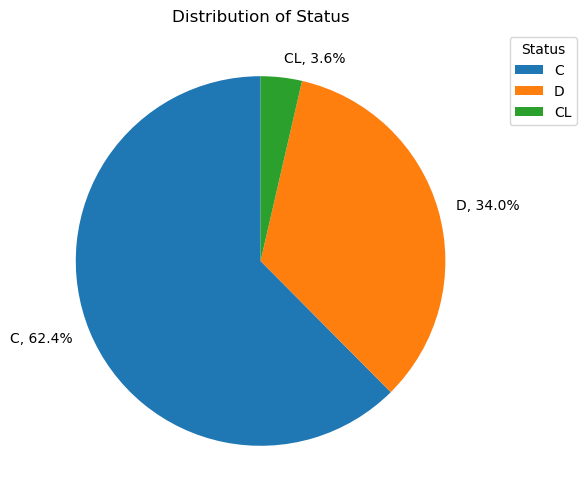

In [69]:
# Counting the observations for each category
status_counts = df_train[TARGET].value_counts()
labels = status_counts.index
sizes = status_counts.values

# Calculating the percentage of each category
percentages = 100.*sizes/sizes.sum()

# Creating the pie chart with percentages in the labels
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=[f"{l}, {s:.1f}%" for l, s in zip(labels, percentages)], startangle=90)
plt.gca().set_aspect("equal")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1), labels=labels, title=TARGET)
plt.title(f"Distribution of {TARGET}")
plt.show()

The classes are imbalanced and CL is a very small class.

Distribution of the features by the target classes:

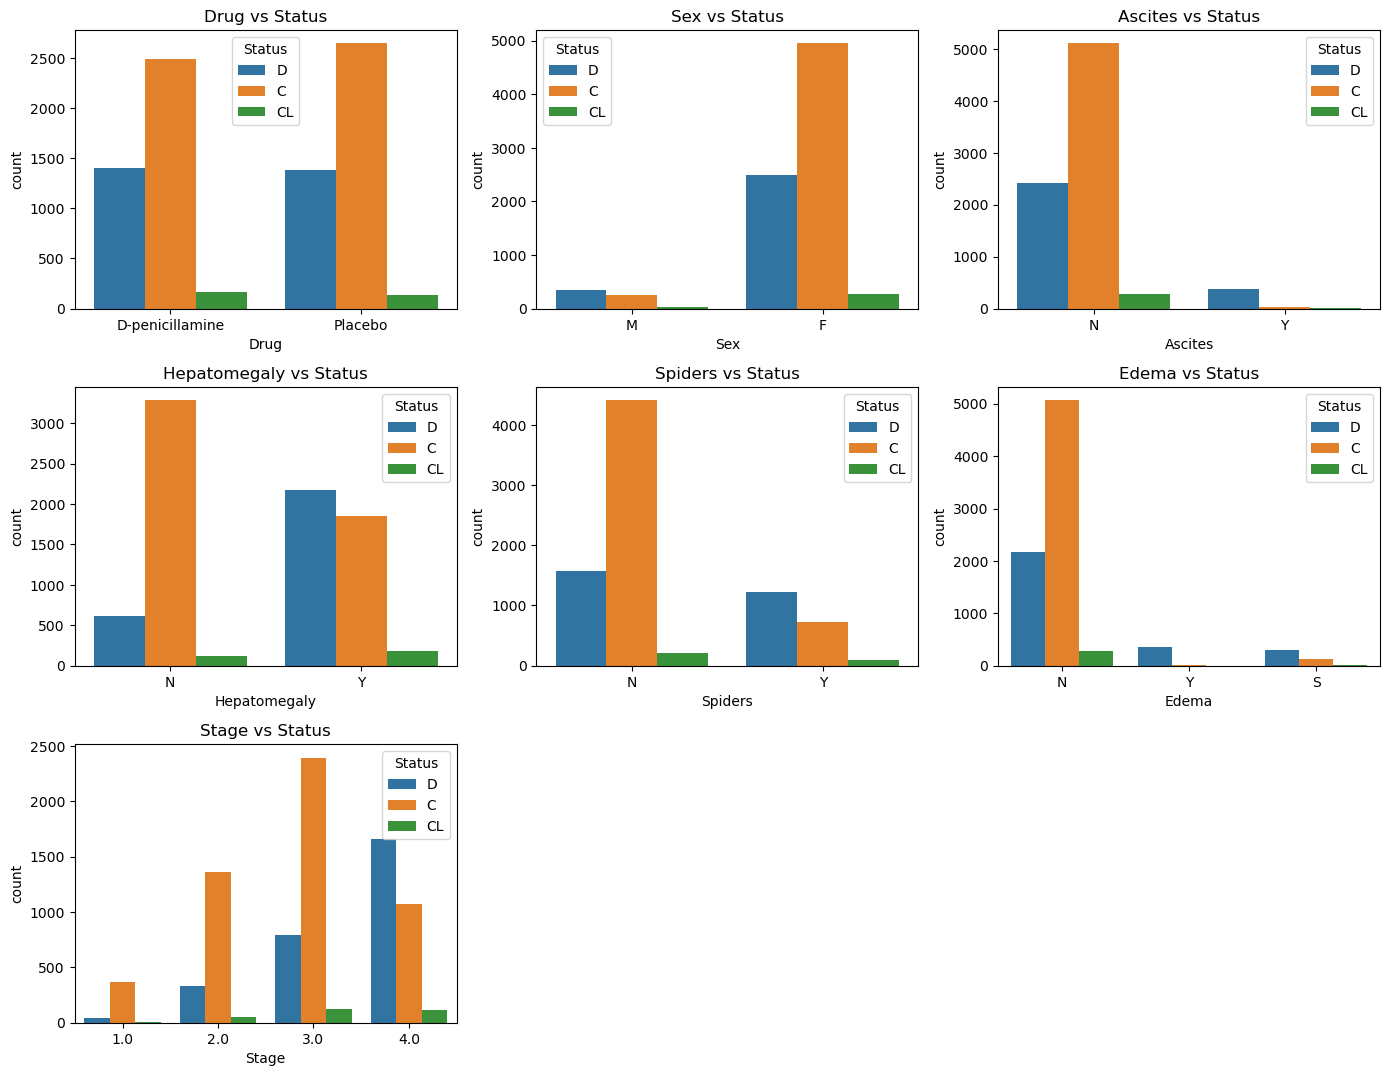

In [70]:
plt.figure(figsize=(14, len(CAT_FEATS) * 2))
for i, col in enumerate(CAT_FEATS):
    plt.subplot(len(CAT_FEATS) // 2 + 1, 3, i + 1)
    sns.countplot(x=col, hue=TARGET, data=df_train)
    plt.title(f"{col} vs {TARGET}")
    plt.tight_layout()


- "drug" appears to have no effect on the target
- death is most common outcome for males, censored for females
- ascites, hepatomegaly, spiders, edema, and stage are associated with death

Distribution of the Target by Continuous Features:

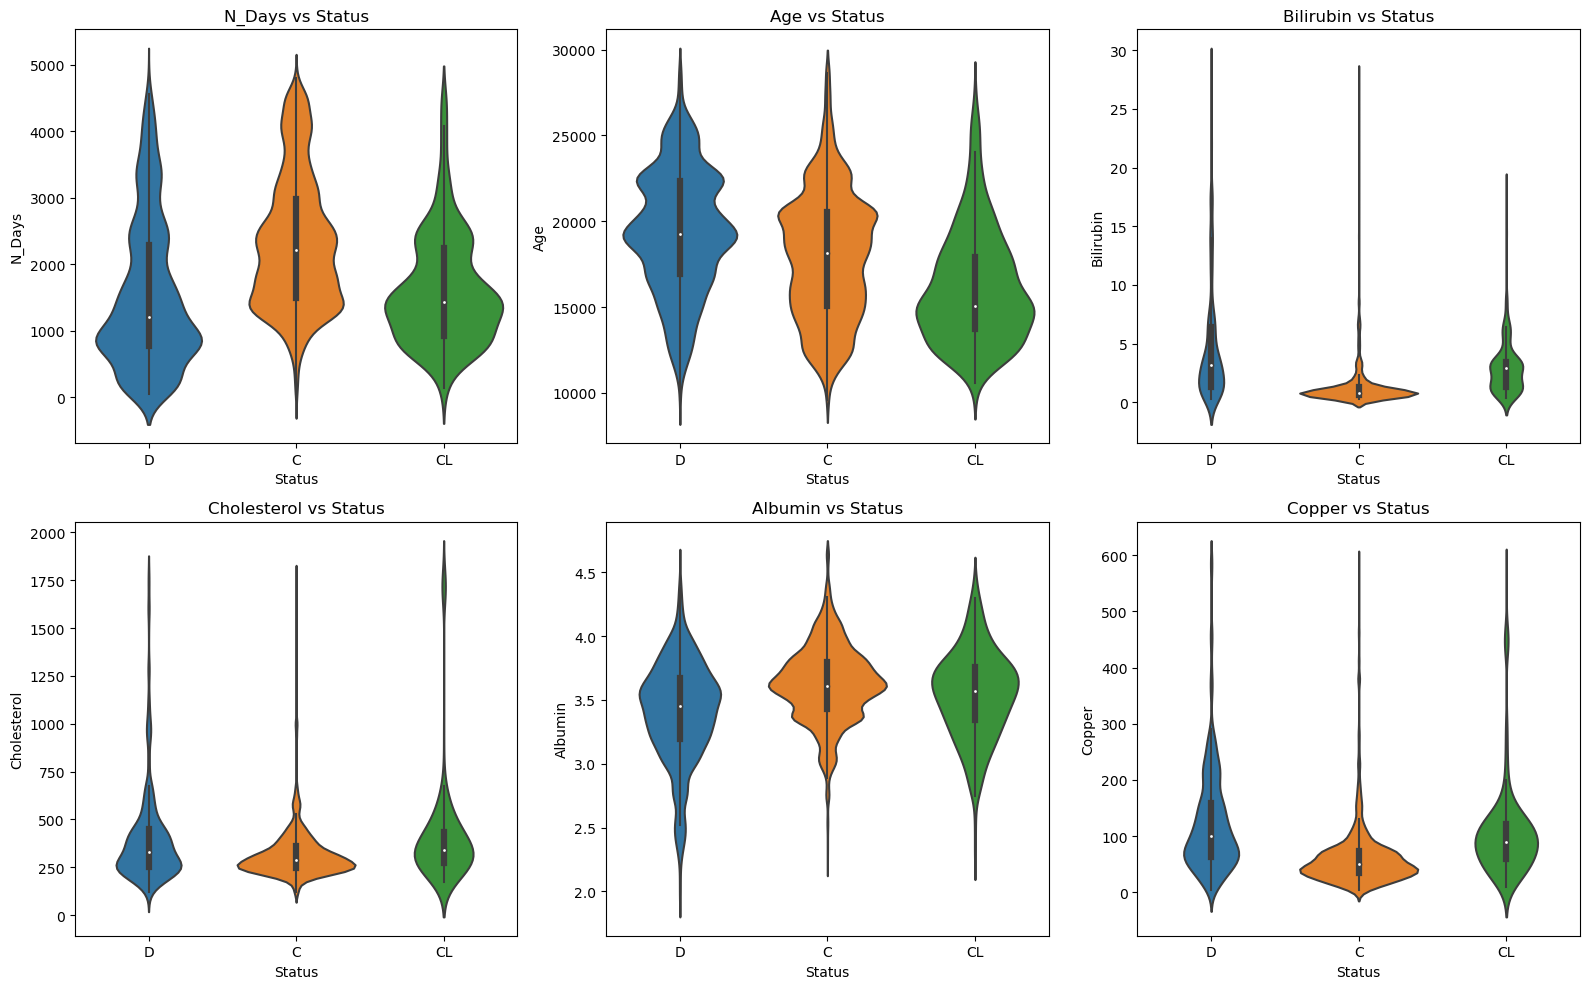

In [71]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
for i, ax in enumerate(axes.flatten()):
    sns.violinplot(x=TARGET, y=NUM_FEATS[i], data=df_train, ax=ax)
    # Set x ticks to be the original labels (inverse transform)
    ax.set_title(f"{NUM_FEATS[i]} vs {TARGET}")
plt.tight_layout()
plt.show()

They are distributed somewhat normally across classes of the target, but there are outliers.

Correlation of the features:

/home/reed/miniconda3/envs/ml/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


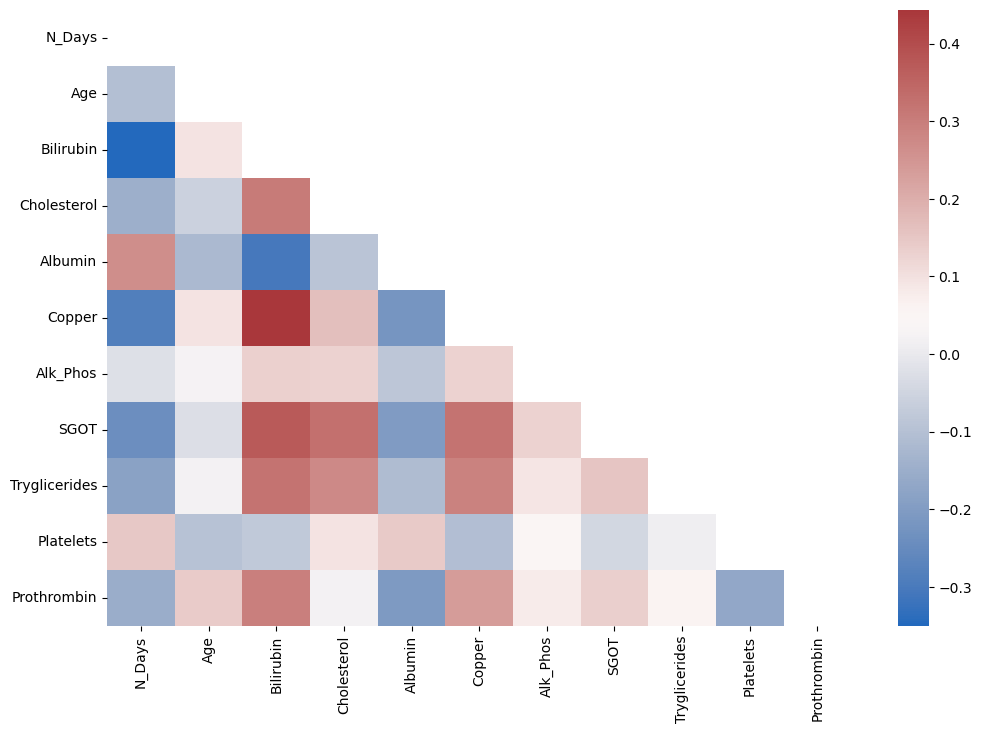

In [72]:
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(df_train[NUM_FEATS].corr(), dtype=bool))
sns.heatmap(df_train[NUM_FEATS].corr(), annot=True, mask=mask, cmap='vlag')
plt.show()

- bilirubin is correlated with albumin, copper, and n days

To investigate correlation by the target classes, use a pairplot:

Mutual Information:

In [74]:
print(df_train.dtypes)
print(len(df_train.columns))

N_Days             int64
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
Status            object
source            object
dtype: object
20


In [75]:
def mi(X, y, discrete_features):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = discrete_features
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

X_mi_raw = df_train.dropna().copy()
y_mi_raw = X_mi_raw['Status']
X_mi_raw = X_mi_raw.iloc[:, 0:18]

# encode the categorical features
X_mi_cat = X_mi_raw[CAT_FEATS]
X_mi_num = np.array(X_mi_raw[NUM_FEATS])
oe = OrdinalEncoder()
X_mi_cat = oe.fit_transform(X_mi_cat)
X_mi_cat = pd.DataFrame(X_mi_cat, columns=CAT_FEATS)
X_mi_num = pd.DataFrame(X_mi_num, columns=NUM_FEATS)

In [76]:
# encode the target
le = LabelEncoder()
y_mi = le.fit_transform(y_mi_raw)

In [87]:
# prep data for MI
# 
cat_mi_scores = mi(X_mi_cat, y_mi, discrete_features=True)
num_mi_scores = mi(X_mi_num, y_mi, discrete_features=False)
mi_scores = pd.concat([cat_mi_scores, num_mi_scores], axis=0)
mi_scores = mi_scores.sort_values(ascending=False)
print("MI Scores:")
print("_________________________")
display(mi_scores)

MI Scores:
_________________________


N_Days           0.201364
Bilirubin        0.189557
Copper           0.174240
Alk_Phos         0.162181
Cholesterol      0.151942
SGOT             0.149240
Platelets        0.145727
Age              0.133512
Prothrombin      0.106936
Tryglicerides    0.095906
Albumin          0.086801
Hepatomegaly     0.080596
Stage            0.074144
Edema            0.059678
Spiders          0.050151
Ascites          0.038826
Sex              0.008539
Drug             0.000366
Name: MI Scores, dtype: float64

The most important variables are all numerical. N_Days, Bilirubin, Copper, and Alk_Phos are the top 4. Drug has no effect at all, as seen in the Status by Features barplots above, so it will be dropped.